<a href="https://colab.research.google.com/github/Rabbia-Ijaz/TryItOut/blob/main/GarmentTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
import glob
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import cv2
from IPython.display import display
!pip install UVTextureConverter
from UVTextureConverter import UVConverter
from UVTextureConverter import Normal2Atlas
from UVTextureConverter import Atlas2Normal

In [148]:
def Display(title1 ,a): #global display func
    name=title1+'.jpg'
    cv2.imwrite(name,a)
    print(title1)
    display(Image(filename=name))

input=""
input_IUV=""

def Inputfunc(input_1,input_1_IUV,target,target_IUV):
  input=input_1
  input_IUV=input_1_IUV
  model_image = Image.open(input_1)
  dense_image = Image.open(input_1_IUV)
  model_image_1 = Image.open(target)
  dense_image_1 = Image.open(target_IUV)
  return input,input_IUV,model_image,dense_image,model_image_1,dense_image_1



In [149]:
input,input_IUV,model_image,dense_image,model_image_1,dense_image_1=Inputfunc("input_7.jpg","input_7_IUV.png","input_8.jpg","input_8_IUV.png")

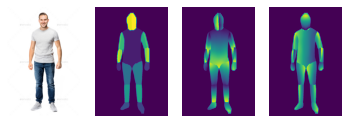

In [150]:
dense_array = np.asarray(dense_image)
model_dense=np.zeros(shape=(3,dense_array[:,:,0].shape[0],dense_array[:,:,0].shape[1]))
model_dense[0]=dense_array[:,:,2]
model_dense[1]=dense_array[:,:,1]
model_dense[2]=dense_array[:,:,0]
model_dense.shape
model_array = np.asarray(model_image)[:model_dense.shape[1],:model_dense.shape[2],:]


figure, axes = plt.subplots(nrows=1, ncols=4)
axes.ravel()[0].imshow(model_array)
axes.ravel()[0].set_axis_off()
axes.ravel()[1].imshow(model_dense[0])
axes.ravel()[1].set_axis_off()
axes.ravel()[2].imshow(model_dense[1])
axes.ravel()[2].set_axis_off()
axes.ravel()[3].imshow(model_dense[2])
axes.ravel()[3].set_axis_off()

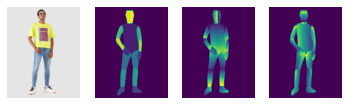

In [151]:
dense_array_1 = np.asarray(dense_image_1)
model_dense_1=np.zeros(shape=(3,dense_array_1[:,:,0].shape[0],dense_array_1[:,:,0].shape[1]))
model_dense_1[0]=dense_array_1[:,:,2]
model_dense_1[1]=dense_array_1[:,:,1]
model_dense_1[2]=dense_array_1[:,:,0]
model_dense_1.shape
model_array_1 = np.asarray(model_image_1)[:model_dense_1.shape[1],:model_dense_1.shape[2],:]

#display
figure, axes = plt.subplots(nrows=1, ncols=4)
axes.ravel()[0].imshow(model_array_1)
axes.ravel()[0].set_axis_off()
axes.ravel()[1].imshow(model_dense_1[0])
axes.ravel()[1].set_axis_off()
axes.ravel()[2].imshow(model_dense_1[1])
axes.ravel()[2].set_axis_off()
axes.ravel()[3].imshow(model_dense_1[2])
axes.ravel()[3].set_axis_off()


In [152]:
solution = 75
solution_float = float(solution) - 1

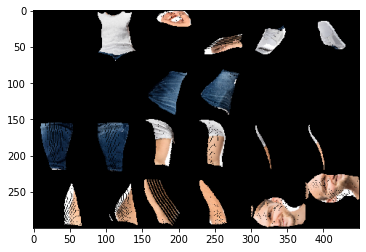

In [153]:
U = model_dense[1, :, :]
V = model_dense[2, :, :]
parts = list()
for PartInd in range(1, 25):
    actual_part = np.zeros((solution, solution, 3))
    x, y = np.where(model_dense[0,:,:] == PartInd)
    if len(x) == 0:
        parts.append(actual_part)
        continue
    u_current_points = U[x, y]
    v_current_points = V[x, y]


    tex_map_coords = ((255-v_current_points)*solution_float/255.).astype(int), (u_current_points*solution_float/255.).astype(int)
    for c in range(3):
        actual_part[tex_map_coords[0], tex_map_coords[1], c] = model_array[x, y, c]

    parts.append(actual_part)


tex_trans, mask_trans = UVConverter.create_texture(input, input_IUV, parts_size=solution, concat=False)

# for display
TextureIm = UVConverter.concat_atlas_tex(tex_trans)  # 800 x 1200 x 3
plt.imshow(TextureIm)


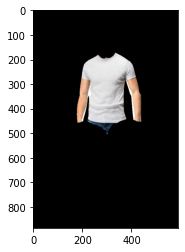

In [154]:
model_image_identity = model_array * np.expand_dims((model_dense[0] == 2)+(model_dense[0] == 15)+(model_dense[0] == 16)+(model_dense[0] == 17)+(model_dense[0] == 18)+(model_dense[0] == 19)+(model_dense[0] == 20)+ (model_dense[0] == 21)+(model_dense[0] == 22), 2)
plt.imshow(model_image_identity)

In [155]:
np.array(parts).shape

(24, 75, 75, 3)

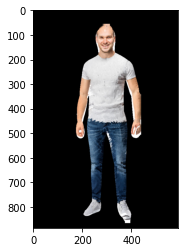

In [156]:
IUV = model_dense

I=model_dense[0,:,:]
U = model_dense[1,:,:]
V = model_dense[2,:,:]

R_im = np.zeros(U.shape)
G_im = np.zeros(U.shape)
B_im = np.zeros(U.shape)

for PartInd in range(1, 25):
    tex = np.array(parts)[PartInd - 1, :, :, :].squeeze()
    R = tex[:,:,0]
    G = tex[:,:,1]
    B = tex[:,:,2]
    ###############
    x,y = np.where(IUV[0,:,:]==PartInd)
    u_current_points = U[x,y]   #  Pixels that belong to this specific part.
    v_current_points = V[x,y]
    ##
    r_current_points = R[((255-v_current_points)*solution_float/255.).astype(int),(u_current_points*solution_float/255.).astype(int)]*255
    g_current_points = G[((255-v_current_points)*solution_float/255.).astype(int),(u_current_points*solution_float/255.).astype(int)]*255
    b_current_points = B[((255-v_current_points)*solution_float/255.).astype(int),(u_current_points*solution_float/255.).astype(int)]*255
    ##  Get the RGB values from the texture images.
    R_im[IUV[0,:,:]==PartInd] = r_current_points
    G_im[IUV[0,:,:]==PartInd] = g_current_points
    B_im[IUV[0,:,:]==PartInd] = b_current_points
generated_image = np.concatenate((R_im[:,:,np.newaxis],G_im[:,:,np.newaxis],B_im[:,:,np.newaxis]), axis =2 ).astype(np.uint8)
#generated_image.shape
plt.imshow(np.uint8(generated_image)*255)

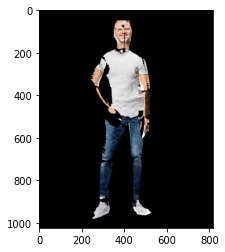

In [157]:
IUV = model_dense_1
U = model_dense_1[1,:,:]
V = model_dense_1[2,:,:]

R_im = np.zeros(U.shape)
G_im = np.zeros(U.shape)
B_im = np.zeros(U.shape)

for PartInd in range(1, 25):
    tex = np.array(parts)[PartInd - 1, :, :, :].squeeze()
    R = tex[:,:,0]
    G = tex[:,:,1]
    B = tex[:,:,2]
    ###############
    x,y = np.where(IUV[0,:,:]==PartInd)
    u_current_points = U[x,y]   #  Pixels that belong to this specific part.
    v_current_points = V[x,y]
    ##
    r_current_points = R[((255-v_current_points)*solution_float/255.).astype(int),(u_current_points*solution_float/255.).astype(int)]*255
    g_current_points = G[((255-v_current_points)*solution_float/255.).astype(int),(u_current_points*solution_float/255.).astype(int)]*255
    b_current_points = B[((255-v_current_points)*solution_float/255.).astype(int),(u_current_points*solution_float/255.).astype(int)]*255
    ##  Get the RGB values from the texture images.
    R_im[IUV[0,:,:]==PartInd] = r_current_points
    G_im[IUV[0,:,:]==PartInd] = g_current_points
    B_im[IUV[0,:,:]==PartInd] = b_current_points
generated_image_1 = np.concatenate((R_im[:,:,np.newaxis],G_im[:,:,np.newaxis],B_im[:,:,np.newaxis]), axis =2 ).astype(np.uint8)

plt.imshow(np.uint8(generated_image_1) * 255)

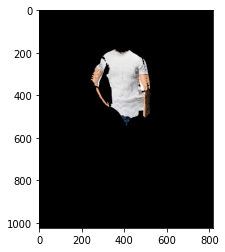

In [158]:
apparel_matrix = np.expand_dims((model_dense_1[0] == 2)+(model_dense_1[0] == 15)+(model_dense_1[0] == 16)+(model_dense_1[0] == 17)+(model_dense_1[0] == 18)+(model_dense_1[0] == 19)+(model_dense_1[0] == 20)+ (model_dense_1[0] == 21)+(model_dense_1[0] == 22), 2)

apparel = generated_image_1 * apparel_matrix * 255
plt.imshow(apparel)


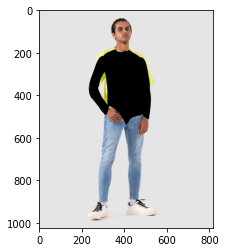

In [159]:
model_image_identity_1 = model_array_1 * np.logical_not(apparel_matrix)
plt.imshow(model_image_identity_1)

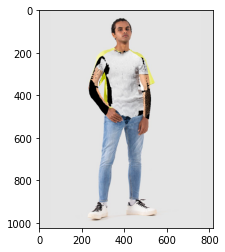

In [160]:
FinalImage=model_image_identity_1 + apparel
plt.imshow(FinalImage)


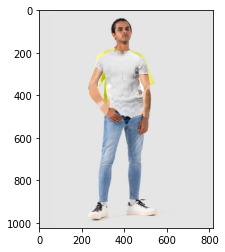

In [161]:
Mask=cv2.imread(target,0)
for i in range(0,FinalImage.shape[0]):
  for j in range(0,FinalImage.shape[1]):
    if (apparel[i][j][0]==0 and apparel[i][j][1]==0 and apparel[i][j][2]==0):
      Mask[i][j]=255
    else:
      Mask[i][j]=0
dst = cv2.inpaint(apparel,Mask,3,cv2.INPAINT_TELEA)

for i in range(0,FinalImage.shape[0]):
  for j in range(0,FinalImage.shape[1]):
    if (model_image_identity_1[i][j][0]==0 and model_image_identity_1[i][j][1]==0 and model_image_identity_1[i][j][2]==0):
      dst[i][j]=dst[i][j]
    else:
      dst[i][j]=model_image_identity_1[i][j]

plt.imshow(dst)

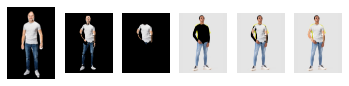

In [162]:
figure, axes = plt.subplots(nrows=1, ncols=6)
axes.ravel()[0].imshow(np.uint8(generated_image)*255)
axes.ravel()[0].set_axis_off()
axes.ravel()[1].imshow(np.uint8(generated_image_1)*255)
axes.ravel()[1].set_axis_off()
axes.ravel()[2].imshow(apparel)
axes.ravel()[2].set_axis_off()
axes.ravel()[3].imshow(model_image_identity_1)
axes.ravel()[3].set_axis_off()
axes.ravel()[4].imshow(FinalImage)
axes.ravel()[4].set_axis_off()
axes.ravel()[5].imshow(dst)
axes.ravel()[5].set_axis_off()